In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools
from ast import literal_eval
import re
from scipy import stats
from random import sample

In [2]:
import sys  
sys.path.insert(0, '../scripts')

from D_plot_specificity_matrix_utils import calc_binding_concordance

In [3]:
import seaborn as sns

In [4]:
import matplotlib.gridspec as gridspec

In [5]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

In [6]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_cd8': literal_converter,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,
              'HLA_pool_cd8':cdr3_lst_converter,
              'HLA_cd8': HLA_cd8_converter,
              'HLA_lst_cd8':literal_converter,'sample_id_lst':literal_converter} #

In [7]:
INPUT = '../experiments/exp13/run2_archive/cat/tables/tcr_barcode.cleaned.csv' #run2
INPUT = '../data/exp9.2_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.csv'
df = pd.read_csv(INPUT, converters=converters) #

In [8]:
df.sample_id_lst[0]

[]

In [9]:
def get_likely_targets(row):
    from itertools import compress
    if (type(row.HLA_cd8) is list) & (type(row.HLA_lst_mhc) is list):
        chec = [item in row.HLA_cd8 for item in row.HLA_lst_mhc]
        idxs = list(compress(range(len(chec)), chec))
        #return [chec, row.HLA_lst_mhc, row.HLA_cd8, idxs]
        #return [row[var][i] for i in idxs]
        if idxs == []:
            return np.nan
        else:
            return [row.HLA_lst_mhc[i] for i in idxs]
    else:
        return np.nan

In [10]:
class Evaluate_Clonotype():
    """
    An instance is a clonotype subset of the data.
    """
    value_bin = set() # clonotypes Evaluate_Clonotype.value_bin
    trash_bin = set() # peptide-HLAs
    ct_checks = dict()
    
    def __init__(self, df, ct, selected_clonotypes, use_relative_umi=False, variable='peptide_HLA'):
        self.df = df[df.ct == ct]
        self.ct = int(ct)
        self.idx = self.df.index
        self.rel_umi = use_relative_umi
        self.fig_flg = 'None'
        self.variable = variable
        
        if self.variable == 'peptide_HLA':
            self.var_lst = 'peptide_HLA_lst'
            self.umi_lst = 'umi_count_lst_mhc'
        elif self.variable == 'sample_id':
            self.var_lst = 'sample_id_lst'
            self.umi_lst = 'umi_count_lst_cd8'
        elif self.variable == 'HLA_cd8':
            self.var_lst = 'HLA_pool_cd8'
            self.umi_lst = 'umi_count_lst_cd8'
        
        # Initialize list of clonotypes
        self.sel_cts = selected_clonotypes
        self.sel_cts.index = self.sel_cts.index.astype(int)
        
        # Initialize matrix of query count per GEM (not method (df is not self))
        self.queries = df[self.var_lst].explode().drop_duplicates() #.unique()
        self.mat = pd.DataFrame(index=self.queries, columns=df.gem.unique()) # added .unique() to index
        
        # Count no. of GEMs within grp that are annotated with a specific pMHC (method?)
        self.gems_per_query = self.df.explode(self.variable).groupby(self.variable).size() # explode only really necessary for HLA_pool_cd8, but doesnt make a difference for other variables.
        self.gems_per_all_q = pd.concat([self.gems_per_query,
                                         pd.Series(0, index=self.queries[~self.queries.isin(self.gems_per_query.index)])])    
        
    def sum_umi(self):
        # Sum UMIs for each peptide across GEMs (multiple peptides per GEM)
        for idx, row in self.df.iterrows():
            if self.variable == 'HLA_cd8':
                var = 'HLA_lst_cd8'
                var_lst = [item for sublist in row[var] for item in sublist if item != '']
                umi_lst = [row[self.umi_lst][i] for i, sublist in enumerate(row[var]) for item in sublist if item != '']
            else:
                var = self.var_lst
                var_lst = row[self.var_lst]
                umi_lst = row[self.umi_lst]
                
            if len(row[self.umi_lst]) == len(row[var]):
                self.mat.loc[var_lst, row.gem] = umi_lst
            else:
                self.mat.loc[var_lst, row.gem] = [0] * len(var_lst)
        #self.mat.fillna(0, inplace=True)
                
    def calc_summary(self):
        self.summary_df = self.mat.sum(axis=1).sort_values(ascending=False).to_frame().rename(columns={0:'s'})
        self.summary_df['avg'] = self.mat.mean(axis=1)
        self.summary_df['col'] = 'grey'
        self.summary_df['r'] = self.summary_df.s / self.summary_df.s.max() # Unnecessary
        
    def calc_relative_umi(self):
        if self.variable == 'peptide_HLA':
            umi = 'umi_count_mhc'
        else:
            umi = 'umi_count_cd8'
        if self.rel_umi:
            self.mat = self.mat / self.df[umi].quantile(0.9, interpolation='lower')
        return self.df[umi] / self.df[umi].quantile(0.9, interpolation='lower')
    
    def select_queries(self, n=11):
        self.selected_queries = self.summary_df.head(n).index
        self.selected_mat = self.mat.loc[self.mat.index.isin(self.selected_queries), self.df[self.df.ct == self.ct].gem]

    def transform_data_for_plotting(self):
        """
        For each row have unique combination of pMHC and GEM.
        """
        self.plt_df = self.selected_mat.melt(ignore_index=False, var_name='gem', value_name='umi').fillna(0) # OBS! new with replace!#.dropna()
        self.plt_df.umi = self.plt_df.umi.astype(int)

    def add_gem_count(self):
        """
        Make a variable for iterating over GEMs (fx in a GIF).
        Not necessary for the ordinary plot.
        """
        dct = (self.plt_df.replace(0,np.nan).dropna().groupby('gem', sort=False).size()
               .to_frame().reset_index().reset_index().set_index('gem')
               .rename(columns={'index':'gem_count',0:'query_count'}))
        dct['gem_count'] = dct.gem_count + 1

        # Make a var for iterating over GEMs
        self.plt_df['gem_count'] = self.plt_df.gem.map(dct.gem_count)

    def def_categories(self):
        self.plt_df.reset_index(inplace=True)
        if self.variable != 'sample_id':
            self.plt_df[self.var_lst] = self.plt_df[self.var_lst].astype("category") #why as category?
            self.plt_df[self.var_lst] = self.plt_df[self.var_lst].cat.set_categories(self.selected_queries)
        else:
            self.plt_df[self.var_lst] = self.plt_df[self.var_lst].fillna('').astype(str) #why do I have nans?
        # sort to color
        self.plt_df.sort_values(by=[self.var_lst,'umi'], ascending=[True,False], inplace=True)
        
    def color_max_umi(self):
        # convert colors to hex
        rgba = sns.color_palette(palette='husl', n_colors=11)
        pep2col = dict()
        peptides = self.plt_df.peptide_HLA_lst.unique()[::-1]
        for i, pep in zip(np.arange(11), peptides):
            pep2col[pep] = matplotlib.colors.rgb2hex(rgba[i])
        
        # Identify peptide with max umi
        dct = inst.plt_df.groupby('gem').umi.max()
        inst.plt_df['umi_max'] = inst.plt_df.gem.map(dct)
        
        # Give the max umi peptide a color and the rest are grey
        inst.plt_df['color'] = inst.plt_df.peptide_HLA_lst.map(pep2col)
        inst.plt_df['color'] = np.where(inst.plt_df.umi != inst.plt_df.umi_max, 'grey', inst.plt_df.color)
        
        self.c2c = {c:c for c in self.plt_df.color.unique()}
        
    def sort_data(self):
        self.plt_df.sort_values([self.var_lst,'color','umi'], ascending=[True, True, False], inplace=True)
            
    # Not needed anymore...
    #def add_scatter(self):
    #    for i, (name, subdf) in reversed(list(enumerate(self.plt_df.groupby('peptide_HLA_lst', sort=False)))): #reversed(list(grouped))
    #        self.plt_df.loc[subdf.index, 'y'] = np.random.normal(i, 0.1, subdf.shape[0])
    
    def transform_to_concordance(self):
        #self.conc_df = (self.plt_df.replace(0,np.nan).dropna().sort_values(by=['gem','umi']) # added .replace(0,np.nan).dropna()
        #                .drop_duplicates(subset='gem', keep='last')
        #                .groupby(self.var_lst).gem.count()
        #                .to_frame())
        #self.conc_df['clonotype'] = f'clonotype {self.ct}'
        #self.conc_df.reset_index(inplace=True)
        #self.conc_df['concordance'] = self.conc_df.gem / self.conc_df.gem.sum()
        #self.conc_df.replace(0, np.nan, inplace=True)
        sub_df = self.df.loc[self.df.peptide_HLA.isin(self.queries),
                             ['peptide_HLA','gems_per_specificity',
                              'gems_per_clonotype','binding_concordance']].drop_duplicates()
        
        self.conc_df = pd.merge(self.summary_df[:11], sub_df,
                                left_index=True, right_on='peptide_HLA', how='left')
        
        self.conc_df.rename(columns={'gems_per_specificity':'gem','binding_concordance':'concordance'}, inplace=True)
        self.conc_df['clonotype'] = f'clonotype {self.ct}'
        self.conc_df.fillna(value={'gem':0,'concordance':0}, inplace=True)
        self.conc_df.fillna(method='ffill', inplace=True)
        
         
    def plot_advanced_figure(self, figname):
        def get_legend_n_handle(l,h,key='gem'):
            leg = list()
            hdl = list()
            if key is None:
                keep = True
            else:
                keep = False
            for i,e in enumerate(l):
                if keep:
                    if int(float(e)) > 0:
                        leg.append(int(float(e)))
                        hdl.append(h[i])
                if e == key:
                    keep = True
            return hdl, leg
        
        fig = plt.figure(figsize=(20,7))
        fig.suptitle(f"Clonotype {self.ct}")

        gs = gridspec.GridSpec(1, 3, width_ratios=[2, 7, 2], wspace=0.2) #, left=0.05
        ax1 = fig.add_subplot(gs[0]) #ax1 = plt.subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[1]) #ax2 = plt.subplot(gs[0,1])
        ax3 = fig.add_subplot(gs[2]) #ax3 = plt.subplot(gs[0, 2])

        ########################
        # Add multipletplot
        ###############################
        tx1 = ax1.twinx()
        
        sns.scatterplot(data=self.plt_df.replace(0,np.nan), x="gem", y='peptide_HLA_lst', size='umi', #[::-1]
                        ax=ax1, legend='brief', sizes=(5,200), hue='color', palette=self.c2c, linewidth=0.1)
        
        h,l = ax1.get_legend_handles_labels()
        h,l = get_legend_n_handle(l, h, key='umi') #None
        ax1.legend(h, l, bbox_to_anchor=(-1, 0.5), loc=10, frameon=False, title='UMI')
        
        sns.scatterplot(data=self.plt_df.replace(0,np.nan), x="gem", y='peptide_HLA_lst', size='umi', #[::-1]
                        ax=tx1, legend=False, sizes=(5,200), hue='color', palette=self.c2c, linewidth=0.1)

        ########################
        # Add boxplot
        ###############################
        # OBS! Filling NaN with 0s to show in the distribution.
        PROPS = {'boxprops':{'alpha':0.3}, #'facecolor':'none', 
                 'medianprops':{'alpha':0.3},
                 'whiskerprops':{'alpha':0.3},
                 'capprops':{'alpha':0.3}}
        EMPTY = {'boxprops':{'alpha':0}, #'facecolor':'none', 
                 'medianprops':{'alpha':0},
                 'whiskerprops':{'alpha':0},
                 'capprops':{'alpha':0}}
        
        ARGS = {'x':"umi", 'y':"peptide_HLA_lst", 'data':self.plt_df, 'showfliers':False}
        order = self.plt_df.peptide_HLA_lst.unique()[::-1]

        tx2 = ax2.twinx() # hack to get matching ticks on the right
        sns.boxplot(**ARGS, **PROPS, order=order, ax=ax2)
        
        sns.stripplot(data=self.plt_df, x="umi", y='peptide_HLA_lst', ax=ax2, order=order, jitter=0.2, edgecolor='white',linewidth=0.5, size=6)
        #sns.boxplot(**ARGS, **PROPS, ax=ax2, order=order) #, order=order
        sns.boxplot(**ARGS, **EMPTY, order=order, ax=tx2)
        #sns.scatterplot(data=self.plt_df, x="umi", y="y", hue='peptide_HLA_lst', legend=False, ax=ax2)

        # Add significance bar
        if self.test_dist():
            l = len(self.plt_df.peptide_HLA_lst.unique()) - 1
            y = [l, l, l-1, l-1] #[0,0,1,1] #
            x0 = self.plt_df.umi.max()
            x1 = x0 * 1.02
            x2 = x0 * 1.025
            x3 = x0 * 1.035

            ax2.plot([x1, x2, x2, x1], y, lw=0.7, c='0') #lw=1.5, 
            ax2.plot(x3, np.mean(y), marker="*", c='0')

        ######################################
        # Add concordance plot
        #########################################
        # Hack to get colorbar
        #x = [self.conc_df.clonotype.unique()[0]] * len(order)
        #plot = ax3.scatter(x, order[::-1], c='blue', alpha=0, cmap='viridis_r', vmin=0, vmax=1) #order[::-1]
        plot = sns.scatterplot(data=self.conc_df, x='clonotype', y='peptide_HLA', alpha=0, #[::-1]
                               palette='viridis_r', ax=ax3)
        sm = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap='viridis_r') # hack for cbar
        sm.set_array([]) # hack for cbar
        fig.colorbar(sm, ax=ax3) #plot
        sns.scatterplot(data=self.conc_df.replace(0, np.nan), x='clonotype', y='peptide_HLA', #[::-1]
                        size='gem', hue='concordance', hue_norm=(0,1), palette='viridis_r', ax=ax3) #g = 

        # Remove automatic sns legend for hue, keep only legend for size.
        h,l = ax3.get_legend_handles_labels()
        h,l = get_legend_n_handle(l, h, key='gem')
        ax3.legend(h, l, bbox_to_anchor=(1.5, 0.5), loc=6, frameon=False, title='GEM') #h[-4:], l[-4:]

        ######################################
        # Prettify
        #########################################

        ax1.set_title('Peptide MHC multiplets')
        ax2.set_title('UMI distribution per peptide MHC')
        ax3.set_title('Concordance')

        xmax = round(self.plt_df.umi.max(), -1)
        ax2.set_xticks(np.arange(0, xmax+10, 10))
        ax3.set_yticks([])

        ax1.set_xticklabels([])
        tx1.set_yticklabels([f'n= {n}' for n in self.plt_df.replace(0,np.nan).dropna().groupby('peptide_HLA_lst').size()]) #[::-1]
        ax2.set_yticklabels([])
        ax3.set_yticklabels([])

        ax1.set_xlabel('%d GEMs' %len(self.plt_df.replace(0,np.nan).dropna().gem.unique()))
        ax1.set_ylabel('Peptide HLA', labelpad=20)
        tx1.set_ylabel('')
        ax2.set_xlabel('Peptide UMI')
        ax2.set_ylabel('')
        tx2.set_ylabel('')
        ax3.set_ylabel('')
        ax3.set_xlabel('')

        tx1.tick_params(axis='y', pad=10) #20

        ax2.spines['bottom'].set_bounds(0, xmax) # Hack to fix x-axis

        sns.despine(trim=True, right=True, ax=ax1)
        sns.despine(trim=True, right=False, ax=tx1)
        sns.despine(trim=True, right=False, ax=ax2)
        sns.despine(trim=True, right=False, ax=tx2)
        sns.despine(trim=True, left=True, ax=ax3) #offset={'left':-5,'right':-5}

        plt.savefig(figname %(self.fig_flg, self.ct), bbox_inches='tight')
        plt.show()
    
    
    def get_plotting_stats(self):
        self.summed_umis = self.summary_df.s.head(10)
        self.summed_gems = (self.mat > 0).sum(axis=1)
        
    def test_dist(self):
        # Select the peptides to test: the most abundant and the second most abundant (UMI wise)
        p1 = self.summary_df.index[0]
        p2 = self.summary_df.index[1]
        # Extract the UMI distribution for the two selected peptides.
        s1 = self.selected_mat.T[p1]#.fillna(0)
        s2 = self.selected_mat.T[p2]#.fillna(0)
        
        n = min(len(s1.dropna()),len(s2.dropna()))
        if n < 10:
            return False
        
        w, p = stats.wilcoxon(s1.fillna(0)-s2.fillna(0), alternative='greater')
        #u, p = stats.mannwhitneyu(s1, s2, alternative="greater") #, method="exact"
        
        if p <= 0.05:
            return True
        return False
        
    #def test_dist(self):
    #    """
    #    H0: No difference in UMI counts between the top two peptides
    #    H1: Top peptide has more UMI counts
    #
    #    If H1, then we assume that the clonotype has a clear preference for that peptide.
    #    """
    #    # Select the peptides to test: the most abundant and the second most abundant (UMI wise)
    #    p1 = self.summary_df.index[0]
    #    p2 = self.summary_df.index[1]
    #    # Extract the UMI distribution for the two selected peptides.
    #    s1 = self.mat.T[p1].dropna().to_list()
    #    s2 = self.mat.T[p2].dropna().to_list()
    #    # If fewer than 5 observations for any of the peptides, then assume H0
    #    n = min(len(s1), len(s2))
    #    if n < 5:
    #        return False
    #
    #    # Repeat experiment XX times to get more robust selection.
    #    p_list = list()
    #    for _ in range(50):
    #        l1 = sample(s1, n)
    #        l2 = sample(s2, n)
    #
    #        t, p = stats.ttest_ind(l1, l2, equal_var=False, alternative='greater')
    #
    #        p_list.append(p)
    #
    #    if np.median(p_list) <= 0.05:
    #        return True
    #    return False
    
    def get_imputed_query(self):
        return self.summary_df.index[0]
    
    def get_remaining_queries(self):
        return self.summary_df.index[1:10]
    
    def update_bins(self):
        Evaluate_Clonotype.value_bin.update([self.ct])
        Evaluate_Clonotype.trash_bin.update(self.summary_df.index[1:10])
        
    def update_variable_analysis(self):
        Evaluate_Clonotype.ct_checks[self.variable] = self.plt_df
        
    def update_flag(self, flag):
        self.fig_flg = flag
        

    def save_figure(self, name):
        plt.savefig(name %(self.fig_flg, self.ct), bbox_inches='tight')

In [19]:
df = calc_binding_concordance(df.copy(),'ct')

In [20]:
bc = df.groupby(['ct']).binding_concordance.max()

In [21]:
low_conc_cts = bc[bc <= 0.5].index

In [22]:
low_conc_cts

Float64Index([  1.0,   3.0,  10.0,  12.0,  15.0,  18.0,  20.0,  21.0,  24.0,
               25.0,  31.0,  35.0,  36.0,  37.0,  41.0,  44.0,  45.0,  46.0,
               47.0,  52.0,  54.0,  72.0,  74.0,  75.0,  79.0,  85.0,  90.0,
               91.0,  93.0,  94.0, 205.0, 219.0, 225.0, 268.0, 381.0, 388.0,
              398.0, 466.0, 594.0],
             dtype='float64', name='ct')

In [23]:
len(df.ct.unique())

329

significant peptide_HLA


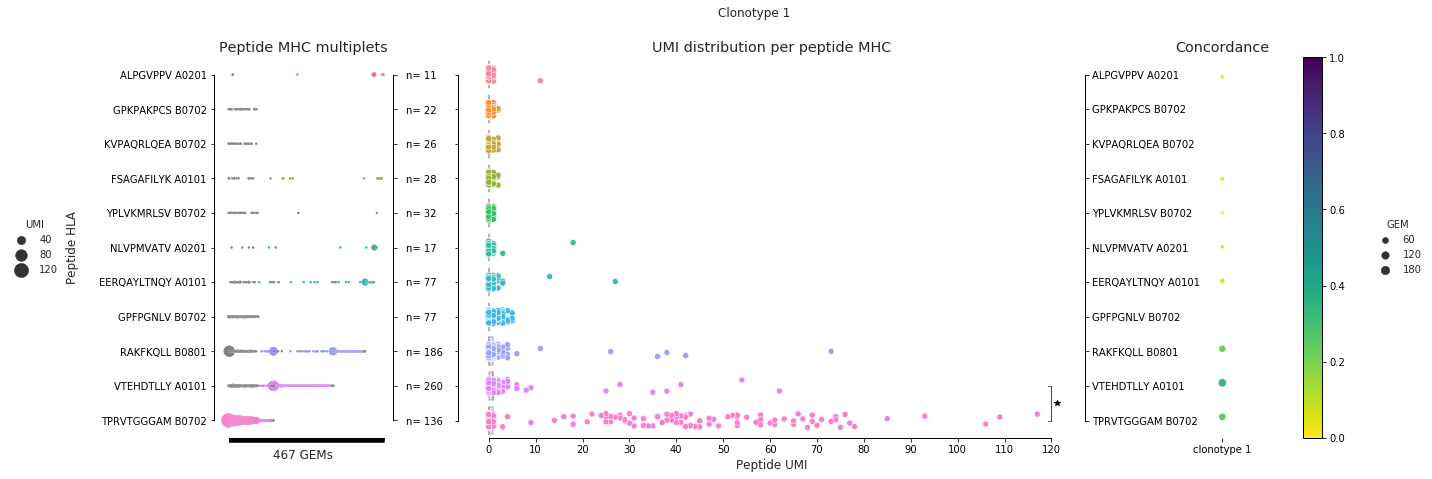

1.0 is credible
1.0
significant peptide_HLA


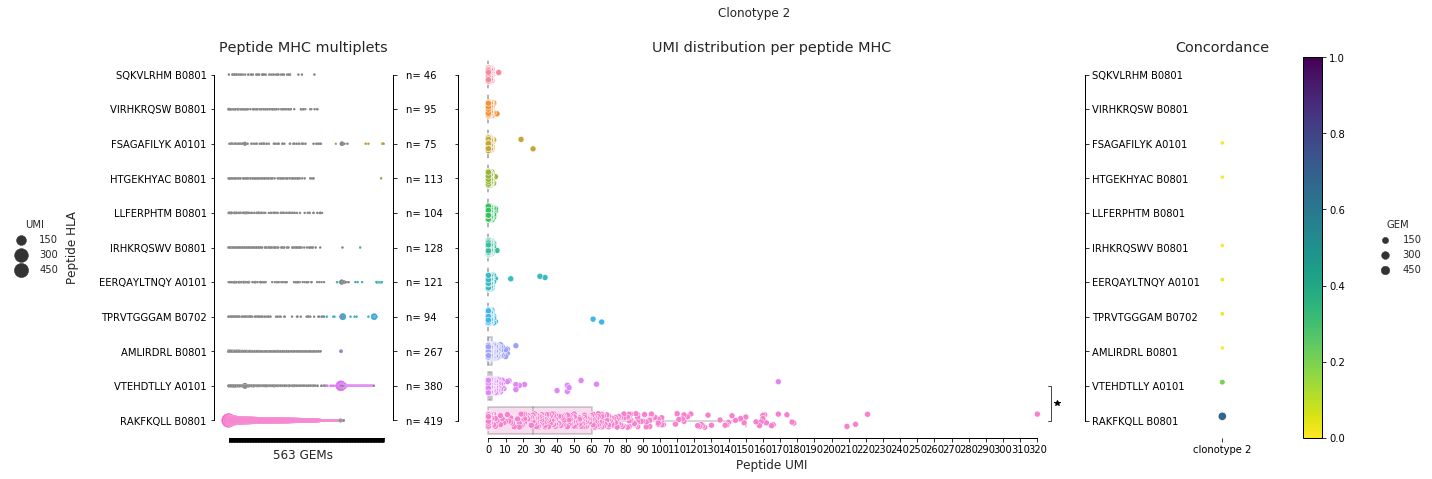

2.0 is credible
2.0


In [173]:
selected_clonotypes = df.groupby('ct').size()

for ct, grp in df.groupby('ct'): #selected_clonotypes.index #[df.ct.isin(low_conc_cts)]
    
    for variable, imp_var in zip(['peptide_HLA'], ['ct_pep']):
        inst = Evaluate_Clonotype(df, ct, selected_clonotypes, variable=variable)
        inst.sum_umi()
        inst.calc_summary()
        #df.loc[instance.idx, 'umi_count_mhc_rel'] = instance.calc_relative_umi()
        inst.select_queries()
        inst.transform_data_for_plotting()
        inst.add_gem_count()
        inst.def_categories()
        inst.color_max_umi()
        inst.sort_data()
        inst.transform_to_concordance() # Only relevant for pMHC...
        inst.update_variable_analysis()

        if inst.test_dist():
            print(f'significant {variable}')
            df.loc[inst.idx, imp_var] = inst.get_imputed_query()
        
            inst.update_bins()
            
        if variable == 'peptide_HLA':
            inst.plot_advanced_figure('fig1_%s_%s.png')
            
    if ct in Evaluate_Clonotype.value_bin:
        inst.update_flag('significant')
        print(f'{ct} is credible')
    else:
        inst.update_flag('insignificant')
        
    print(ct)
    if ct == 2:
        break

# Possible fix:
# https://github.com/mwaskom/seaborn/commit/1a537c100dd58c4a22187b8f2a02ab53a88030a2
# Check the sns version on computerome.

In [120]:
inst.conc_df

,s,avg,col,r,peptide_HLA,gem,gems_per_clonotype,concordance,clonotype
0.0,21524.0,51.369928,grey,1.000000,RAKFKQLL B0801,395.0,587.0,0.672913,clonotype 2
5.0,1281.0,3.371053,grey,0.059515,VTEHDTLLY A0101,116.0,587.0,0.197615,clonotype 2
188.0,737.0,2.760300,grey,0.034241,AMLIRDRL B0801,1.0,587.0,0.001704,clonotype 2
87.0,250.0,2.659574,grey,0.011615,TPRVTGGGAM B0702,13.0,587.0,0.022147,clonotype 2
69.0,217.0,1.793388,grey,0.010082,EERQAYLTNQY A0101,18.0,587.0,0.030664,clonotype 2
1203.0,159.0,1.242188,grey,0.007387,IRHKRQSWV B0801,1.0,587.0,0.001704,clonotype 2
NaN,133.0,1.278846,grey,0.006179,LLFERPHTM B0801,0.0,587.0,0.000000,clonotype 2
1968.0,131.0,1.159292,grey,0.006086,HTGEKHYAC B0801,1.0,587.0,0.001704,clonotype 2
242.0,127.0,1.693333,grey,0.005900,FSAGAFILYK A0101,6.0,587.0,0.010221,clonotype 2
NaN,123.0,1.294737,grey,0.005715,VIRHKRQSW B0801,0.0,587.0,0.000000,clonotype 2


In [50]:
inst.plt_df['mp'] = inst.plt_df.gem.map(dct)

In [53]:
inst.plt_df['lb'] = inst.plt_df.umi == inst.plt_df.mp

In [36]:
inst.plt_df[inst.plt_df.gem == 'ACTGAGTGTGACTACT-1']

,peptide_HLA_lst,gem,umi,gem_count,umi_max,color
543,TPRVTGGGAM B0702,ACTGAGTGTGACTACT-1,0,NaN,0,#f77189
540,VTEHDTLLY A0101,ACTGAGTGTGACTACT-1,0,NaN,0,#e18632
542,RAKFKQLL B0801,ACTGAGTGTGACTACT-1,0,NaN,0,#b59a32
546,GPFPGNLV B0702,ACTGAGTGTGACTACT-1,0,NaN,0,#8ba731
541,EERQAYLTNQY A0101,ACTGAGTGTGACTACT-1,0,NaN,0,#32b258
548,NLVPMVATV A0201,ACTGAGTGTGACTACT-1,0,NaN,0,#35ae95
547,YPLVKMRLSV B0702,ACTGAGTGTGACTACT-1,0,NaN,0,#37abb2
544,FSAGAFILYK A0101,ACTGAGTGTGACTACT-1,0,NaN,0,#39a7d6
545,KVPAQRLQEA B0702,ACTGAGTGTGACTACT-1,0,NaN,0,#8f93f4
549,GPKPAKPCS B0702,ACTGAGTGTGACTACT-1,0,NaN,0,#db70f4


In [31]:
lol = inst.plt_df.groupby('gem').color.unique()

In [32]:
lol[lol.apply(len) > 2]

gem
AACTCCCCAATGACCT-1    [#f77189, #e18632, #b59a32, #8ba731, #32b258, ...
ACCAGTACAAAGGTGC-1                    [#f77189, #e18632, grey, #32b258]
ACGAGGACAATCACAC-1                             [grey, #b59a32, #32b258]
ACTGAGTGTGACTACT-1    [#f77189, #e18632, #b59a32, #8ba731, #32b258, ...
AGATTGCTCCGAACGC-1                             [grey, #e18632, #39a7d6]
                                            ...                        
TGGACGCAGTCGATAA-1                             [grey, #e18632, #39a7d6]
TGGGAAGTCTATGTGG-1    [#f77189, #e18632, #b59a32, #8ba731, #32b258, ...
TGGTTAGGTGACCAAG-1                             [grey, #e18632, #b59a32]
TGTTCCGGTCATCCCT-1                    [#f77189, grey, #32b258, #39a7d6]
TTGCCGTCATATACCG-1                    [grey, #b59a32, #32b258, #39a7d6]
Name: color, Length: 85, dtype: object

In [66]:
inst.conc_df

,s,avg,col,r,peptide_HLA,gem,gems_per_clonotype,concordance,clonotype
17.0,4357.0,32.036765,grey,1.000000,TPRVTGGGAM B0702,120.0,504.0,0.238095,clonotype 1
1.0,654.0,2.515385,grey,0.150103,VTEHDTLLY A0101,166.0,504.0,0.329365,clonotype 1
2.0,466.0,2.505376,grey,0.106954,RAKFKQLL B0801,109.0,504.0,0.216270,clonotype 1
NaN,164.0,2.129870,grey,0.037641,GPFPGNLV B0702,0.0,504.0,0.000000,clonotype 1
496.0,126.0,1.636364,grey,0.028919,EERQAYLTNQY A0101,28.0,504.0,0.055556,clonotype 1
215.0,36.0,2.117647,grey,0.008263,NLVPMVATV A0201,9.0,504.0,0.017857,clonotype 1
514.0,32.0,1.000000,grey,0.007345,YPLVKMRLSV B0702,2.0,504.0,0.003968,clonotype 1
88.0,31.0,1.107143,grey,0.007115,FSAGAFILYK A0101,16.0,504.0,0.031746,clonotype 1
NaN,31.0,1.192308,grey,0.007115,KVPAQRLQEA B0702,0.0,504.0,0.000000,clonotype 1
NaN,25.0,1.136364,grey,0.005738,GPKPAKPCS B0702,0.0,504.0,0.000000,clonotype 1


In [96]:
conc_df = inst.df.loc[inst.df.peptide_HLA.isin(inst.queries),
            ['peptide_HLA','gems_per_specificity', 'ct','gems_per_clonotype','binding_concordance']].drop_duplicates()

In [121]:
inst.conc_df

,s,avg,col,r,peptide_HLA,gem,gems_per_clonotype,concordance,clonotype
99.0,500.0,3.597122,grey,1.000,RVRAYTYSK A0301,124.0,165.0,0.751515,clonotype 2
997.0,62.0,1.409091,grey,0.124,TPRVTGGGAM B0702,13.0,165.0,0.078788,clonotype 2
180.0,36.0,1.285714,grey,0.072,RPHERNGFTV B0702,6.0,165.0,0.036364,clonotype 2
636.0,28.0,1.333333,grey,0.056,TPSVSSSISSL B0702,5.0,165.0,0.030303,clonotype 2
3000.0,24.0,1.090909,grey,0.048,CLGGLLTMV A0201,3.0,165.0,0.018182,clonotype 2
5008.0,22.0,1.222222,grey,0.044,RPPIFIRRL B0702,4.0,165.0,0.024242,clonotype 2
3077.0,13.0,1.083333,grey,0.026,YVLDHLIVV A0201,4.0,165.0,0.024242,clonotype 2
2612.0,11.0,1.000000,grey,0.022,VLEETSVML A0201,3.0,165.0,0.018182,clonotype 2
5733.0,7.0,1.166667,grey,0.014,RPHERNGFTVL B0702,2.0,165.0,0.012121,clonotype 2
NaN,1.0,1.000000,grey,0.002,FLYALALLL A0201,0.0,165.0,0.000000,clonotype 2


In [104]:
pd.merge(inst.summary_df[:11], conc_df, left_index=True,right_on='peptide_HLA', how='left').fillna(value={})

,s,avg,col,r,peptide_HLA,gems_per_specificity,ct,gems_per_clonotype,binding_concordance
99.0,500.0,3.597122,grey,1.000,RVRAYTYSK A0301,124.0,2.0,165.0,0.751515
997.0,62.0,1.409091,grey,0.124,TPRVTGGGAM B0702,13.0,2.0,165.0,0.078788
180.0,36.0,1.285714,grey,0.072,RPHERNGFTV B0702,6.0,2.0,165.0,0.036364
636.0,28.0,1.333333,grey,0.056,TPSVSSSISSL B0702,5.0,2.0,165.0,0.030303
3000.0,24.0,1.090909,grey,0.048,CLGGLLTMV A0201,3.0,2.0,165.0,0.018182
5008.0,22.0,1.222222,grey,0.044,RPPIFIRRL B0702,4.0,2.0,165.0,0.024242
3077.0,13.0,1.083333,grey,0.026,YVLDHLIVV A0201,4.0,2.0,165.0,0.024242
2612.0,11.0,1.000000,grey,0.022,VLEETSVML A0201,3.0,2.0,165.0,0.018182
5733.0,7.0,1.166667,grey,0.014,RPHERNGFTVL B0702,2.0,2.0,165.0,0.012121
NaN,1.0,1.000000,grey,0.002,FLYALALLL A0201,bff,bff,bff,bff


In [100]:
inst.queries[~inst.queries.isin(conc_df.peptide_HLA)]

81     FLYALALLL A0201
102    GLCTLVAML A0201
603    GILGFVFTL A0201
Name: peptide_HLA_lst, dtype: object

In [90]:
df.loc[df.ct==2,['peptide_HLA','gems_per_specificity', 'gems_per_clonotype','binding_concordance']].drop_duplicates('peptide_HLA')

,peptide_HLA,gems_per_specificity,gems_per_clonotype,binding_concordance
99,RVRAYTYSK A0301,124,165,0.751515
180,RPHERNGFTV B0702,6,165,0.036364
636,TPSVSSSISSL B0702,5,165,0.030303
997,TPRVTGGGAM B0702,13,165,0.078788
2612,VLEETSVML A0201,3,165,0.018182
3000,CLGGLLTMV A0201,3,165,0.018182
3077,YVLDHLIVV A0201,4,165,0.024242
5008,RPPIFIRRL B0702,4,165,0.024242
5642,NLVPMVATV A0201,1,165,0.006061
5733,RPHERNGFTVL B0702,2,165,0.012121


In [33]:
sample_hla_dct = {1:['A0201'],
                  2:['A0201'],
                  3:['A0201'],
                  4:['A0301', 'B0702'],
                  5:['A0301', 'B0702'],
                  6:['A0201', 'B0702'],
                  7:['B0702'],
                  8:['B0702'],
                  9:['B0702'],
                  10:['A0201','A0301']}

In [34]:
df['sample_hla'] = df.ct_sample.map(sample_hla_dct)
#df.sample_hla.fillna('', inplace=True)

In [208]:
clf = tree.DecisionTreeClassifier(min_samples_split=10, max_depth=5) # 
clf = clf.fit(X_train, y_train)

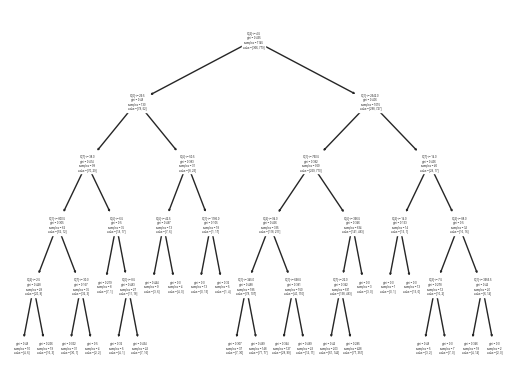

In [152]:
tree.plot_tree(clf)
plt.show()

In [209]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(min_samples_split=8, max_depth=5, random_state=0).fit(X, y)

In [178]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=50).fit(X, y)

In [172]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, penalty='l2').fit(X, y)

In [196]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(5,), random_state=1).fit(X, y)

/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [47]:
plt_df = instance.plt_df

In [65]:
# selected_clonotypes = df.groupby('ct').size()
# 
# ct = 1
# 
# instance = Evaluate_Clonotype(df, ct, selected_clonotypes, use_relative_umi=False)
# instance.sum_umi()
# instance.calc_summary()
# 
# if instance.test_dist():
#     df.loc[instance.idx, 'ct_pep'] = instance.get_imputed_peptide()
# 
#     instance.update_bins()
#     instance.update_flag('significant')
# else:
#     instance.update_flag('insignificant')
# 
# selected_peptides = instance.summary_df.head(11).index
# 
# sub_mat = instance.mat[instance.mat.index.isin(selected_peptides)]
# 
# plt_df = sub_mat.melt(ignore_index=False, var_name='gem', value_name='umi').dropna()
# 
# dct = plt_df.groupby('gem', sort=False).size().to_frame().reset_index().reset_index().set_index('gem').rename(columns={'index':'gem_count',0:'peptide_count'})
# dct['gem_count'] = dct.gem_count + 1
# 
# # Make a var for iterating over GEMs
# plt_df['gem_count'] = plt_df.gem.map(dct.gem_count)
# plt_df.reset_index(inplace=True)
# 
# # Sort according to summary
# plt_df.peptide_HLA_lst = plt_df.peptide_HLA_lst.astype("category")
# plt_df['peptide_HLA_lst'] = plt_df.peptide_HLA_lst.cat.set_categories(selected_peptides) # instead of inplace
# plt_df.sort_values(by='peptide_HLA_lst', inplace=True)
# 
# # Add scatter values
# for i, (name, subdf) in enumerate(plt_df.groupby('peptide_HLA_lst', sort=False)): #reversed(list(grouped))
#     plt_df.loc[subdf.index, 'y'] = np.random.normal(i, 0.1, subdf.shape[0])
#     
# plt_df['clonotype'] = f'clonotype {ct}'

In [80]:
inst.plt_df['umi_big'] = inst.plt_df.umi * 50

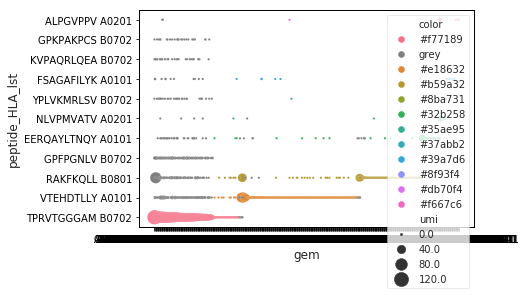

In [45]:
sns.scatterplot(data=inst.plt_df.replace(0, np.nan).sort_values(['peptide_HLA_lst','color','umi'], ascending=[True, True, False]), x="gem", y='peptide_HLA_lst', size='umi', sizes=(5,200), hue='color', palette=inst.c2c, linewidth=0.1) #, legend='brief'
plt.show()

In [113]:
inst.plt_df.peptide_HLA_lst.unique()

['TPRVTGGGAM B0702', 'VTEHDTLLY A0101', 'RAKFKQLL B0801', 'GPFPGNLV B0702', 'EERQAYLTNQY A0101', ..., 'YPLVKMRLSV B0702', 'FSAGAFILYK A0101', 'KVPAQRLQEA B0702', 'GPKPAKPCS B0702', 'ALPGVPPV A0201']
Length: 11
Categories (11, object): ['TPRVTGGGAM B0702', 'VTEHDTLLY A0101', 'RAKFKQLL B0801', 'GPFPGNLV B0702', ..., 'FSAGAFILYK A0101', 'KVPAQRLQEA B0702', 'GPKPAKPCS B0702', 'ALPGVPPV A0201']

In [121]:
gem_lol = inst.plt_df[(inst.plt_df.peptide_HLA_lst == 'FSAGAFILYK A0101') & (inst.plt_df.color != 'grey')].gem

In [ ]:
inst.plt_df[inst.plt_df.gem.isin(gem_lol)].head(60)

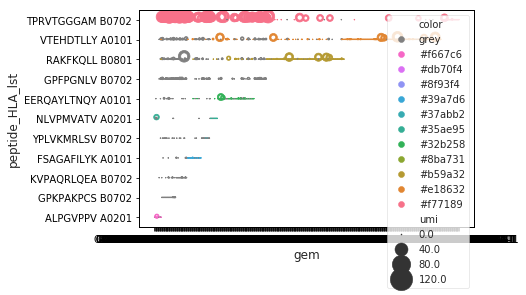

In [89]:
sns.scatterplot(data=inst.plt_df.replace(0, np.nan)[::-1], x="gem", y='peptide_HLA_lst', size='umi', sizes=(1,500), hue='color', palette=c2c, marker='$\circ$', edgecolor='face') #, legend='brief'
plt.show()

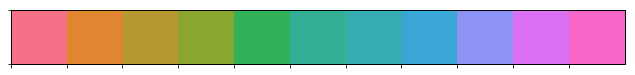

In [19]:
sns.palplot(sns.color_palette(palette='husl', n_colors=11))

In [52]:
inst.plt_df.peptide_HLA_lst.unique()[::-1]

['ALPGVPPV A0201', 'GPKPAKPCS B0702', 'KVPAQRLQEA B0702', 'FSAGAFILYK A0101', 'YPLVKMRLSV B0702', ..., 'EERQAYLTNQY A0101', 'GPFPGNLV B0702', 'RAKFKQLL B0801', 'VTEHDTLLY A0101', 'TPRVTGGGAM B0702']
Length: 11
Categories (11, object): ['TPRVTGGGAM B0702', 'VTEHDTLLY A0101', 'RAKFKQLL B0801', 'GPFPGNLV B0702', ..., 'FSAGAFILYK A0101', 'KVPAQRLQEA B0702', 'GPKPAKPCS B0702', 'ALPGVPPV A0201']

In [27]:
import matplotlib
rgba = sns.color_palette(palette='husl', n_colors=11)
pep2col = dict()
for i, pep in zip(np.arange(11), inst.plt_df.peptide_HLA_lst.unique()):
    #rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(pep, matplotlib.colors.rgb2hex(rgba[i]))
    pep2col[pep] = matplotlib.colors.rgb2hex(rgba[i])

TPRVTGGGAM B0702 #f77189
VTEHDTLLY A0101 #e18632
RAKFKQLL B0801 #b59a32
GPFPGNLV B0702 #8ba731
EERQAYLTNQY A0101 #32b258
NLVPMVATV A0201 #35ae95
YPLVKMRLSV B0702 #37abb2
FSAGAFILYK A0101 #39a7d6
KVPAQRLQEA B0702 #8f93f4
GPKPAKPCS B0702 #db70f4
ALPGVPPV A0201 #f667c6


In [52]:
c2c = {c:c for c in inst.plt_df.color.unique()}

In [41]:
dct = inst.plt_df.groupby('gem').umi.max()
inst.plt_df['umi_max'] = inst.plt_df.gem.map(dct)

inst.plt_df['color'] = inst.plt_df.peptide_HLA_lst.map(pep2col)
inst.plt_df['color'] = np.where(inst.plt_df.umi != inst.plt_df.umi_max, 'grey', inst.plt_df.color)

In [42]:
inst.plt_df

,peptide_HLA_lst,gem,umi,gem_count,umi_max,color
4536,TPRVTGGGAM B0702,TAGAGCTTCCGCATAA-1,0,382.0,1,grey
510,TPRVTGGGAM B0702,ACGTCAATCGAGGTAG-1,1,46.0,1,#f77189
2490,TPRVTGGGAM B0702,CGTTAGAGTAATAGCA-1,1,208.0,1,#f77189
2479,TPRVTGGGAM B0702,CGTGAGCTCCTGCAGG-1,0,NaN,0,#f77189
2468,TPRVTGGGAM B0702,CGTGAGCCAAGGTGTG-1,0,207.0,2,grey
...,...,...,...,...,...,...
2607,ALPGVPPV A0201,CTAGCCTCAGGATCGA-1,0,219.0,1,grey
2596,ALPGVPPV A0201,CTAGCCTAGTTAACGA-1,0,218.0,1,grey
2585,ALPGVPPV A0201,CTAGAGTTCCAAGCCG-1,0,217.0,42,grey
2750,ALPGVPPV A0201,CTCTACGAGGCTACGA-1,0,NaN,0,#f667c6


In [194]:
lol = (plt_df.sort_values(by=['gem','umi'])
       .drop_duplicates(subset='gem', keep='last')
       .groupby('peptide_HLA_lst').gem.count()
       .to_frame())

In [195]:
lol['clonotype'] = f'clonotype {ct}'

In [196]:
lol.reset_index(inplace=True)

In [197]:
lol['concordance'] = lol.gem / lol.gem.sum()

In [198]:
#lol.replace(0, np.nan, inplace=True)

In [199]:
lol

,peptide_HLA_lst,gem,clonotype,concordance
0,NLVPMVATV A0201,32,clonotype 3.0,0.178771
1,VTEHDTLLY A0101,64,clonotype 3.0,0.357542
2,RAKFKQLL B0801,43,clonotype 3.0,0.240223
3,ALPGVPPV A0201,2,clonotype 3.0,0.011173
4,EERQAYLTNQY A0101,15,clonotype 3.0,0.083799
5,TPRVTGGGAM B0702,16,clonotype 3.0,0.089385
6,FISPQLQRI A0201,0,clonotype 3.0,0.000000
7,LLFERPHTM B0801,0,clonotype 3.0,0.000000
8,YLFHKEPTW A0201,0,clonotype 3.0,0.000000
9,PSTPLKPL B0702,1,clonotype 3.0,0.005587


In [40]:
inst.conc_df

,s,avg,col,r,peptide_HLA,gem,gems_per_clonotype,concordance,clonotype
17.0,4357.0,32.036765,grey,1.000000,TPRVTGGGAM B0702,120.0,504.0,0.238095,clonotype 1
1.0,654.0,2.515385,grey,0.150103,VTEHDTLLY A0101,166.0,504.0,0.329365,clonotype 1
2.0,466.0,2.505376,grey,0.106954,RAKFKQLL B0801,109.0,504.0,0.216270,clonotype 1
NaN,164.0,2.129870,grey,0.037641,GPFPGNLV B0702,0.0,504.0,0.000000,clonotype 1
496.0,126.0,1.636364,grey,0.028919,EERQAYLTNQY A0101,28.0,504.0,0.055556,clonotype 1
215.0,36.0,2.117647,grey,0.008263,NLVPMVATV A0201,9.0,504.0,0.017857,clonotype 1
514.0,32.0,1.000000,grey,0.007345,YPLVKMRLSV B0702,2.0,504.0,0.003968,clonotype 1
88.0,31.0,1.107143,grey,0.007115,FSAGAFILYK A0101,16.0,504.0,0.031746,clonotype 1
NaN,31.0,1.192308,grey,0.007115,KVPAQRLQEA B0702,0.0,504.0,0.000000,clonotype 1
NaN,25.0,1.136364,grey,0.005738,GPKPAKPCS B0702,0.0,504.0,0.000000,clonotype 1


In [128]:
order = inst.plt_df.peptide_HLA_lst.unique()[::-1]

In [133]:
[0]*len(order)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [150]:
[inst.conc_df.clonotype.unique()[0]] * len(order)

['clonotype 1',
 'clonotype 1',
 'clonotype 1',
 'clonotype 1',
 'clonotype 1',
 'clonotype 1',
 'clonotype 1',
 'clonotype 1',
 'clonotype 1',
 'clonotype 1',
 'clonotype 1']

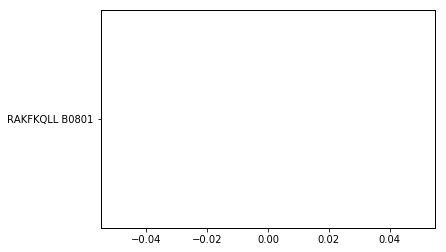

In [137]:
fig, ax = plt.subplots()
ax.scatter([1]*len(order), order[::-1], c=[np.nan]*len(order), cmap='viridis_r', vmin=0, vmax=1)
#sns.scatterplot(data=inst.conc_df.replace(0, np.nan), x='clonotype', y='peptide_HLA',
#                    size='gem', hue='concordance', hue_norm=(0,1), palette='viridis_r', ax=ax)
plt.show()

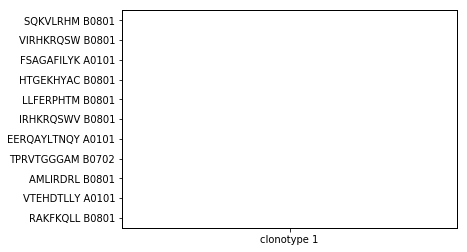

In [145]:
plt.scatter(['clonotype 1']*len(order), order[::-1], alpha=0)

In [120]:
def get_legend_n_handle(l,h,key='gem'):
    leg = list()
    hdl = list()
    keep = False
    for i,e in enumerate(l):
        if keep:
            if int(float(e)) > 0:
                leg.append(int(float(e)))
                hdl.append(h[i])
        if e == key:
            keep = True
            leg.append(e)
            hdl.append(h[i])
    return hdl, leg

/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/matplotlib/colorbar.py:214: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


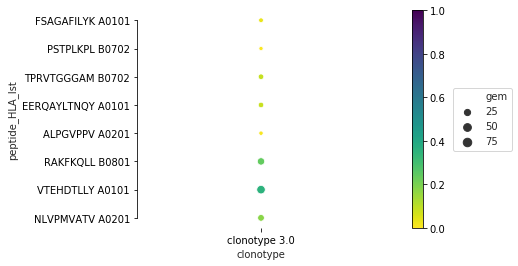

In [121]:
plot = plt.scatter([], [], c=[], cmap='viridis_r', vmin=0, vmax=1)
#plt.clf()
plt.colorbar(plot)
g = sns.scatterplot(data=lol,
                x='clonotype', y='peptide_HLA_lst', size='gem', hue='concordance', hue_norm=(0,1), palette='viridis_r')

h,l = g.get_legend_handles_labels()
#plt.legend(h[-5:],l[-5:],bbox_to_anchor=(1.2, 0.5), loc=6)
hn,ln = get_legend_n_handle(l,h,key='gem')
plt.legend(hn,ln,bbox_to_anchor=(1.2, 0.5), loc=6)
sns.despine(trim=True, offset={'left':-10,'right':-10})
plt.show()

In [122]:
PROPS = {
    'boxprops':{'alpha':0.3}, #'facecolor':'none', 
    'medianprops':{'alpha':0.3},
    'whiskerprops':{'alpha':0.3},
    'capprops':{'alpha':0.3}
}
EMPTY = {
    'boxprops':{'alpha':0}, #'facecolor':'none', 
    'medianprops':{'alpha':0},
    'whiskerprops':{'alpha':0},
    'capprops':{'alpha':0}
}
ARGS = {'x':"umi", 'y':"peptide_HLA_lst", 'data':plt_df, 'showfliers':False}
#x="umi", y="peptide_HLA_lst", data=plt_df, showfliers=False

In [123]:
n = plt_df.gem_count.max()

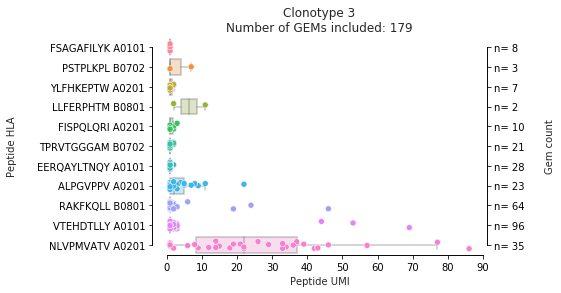

In [185]:
order = plt_df.peptide_HLA_lst.unique()[::-1]
ax = sns.boxplot(**ARGS, **PROPS, order=order) # boxprops=dict(alpha=0.3)
sns.stripplot(data=plt_df, ax=ax, x="umi", y='peptide_HLA_lst', order=order, jitter=0.2, edgecolor='white',linewidth=0.5, size=6)
tx = ax.twinx()
sns.boxplot(**ARGS, ax=tx, **EMPTY) #boxprops=dict(alpha=0)
#sns.scatterplot(data=plt_df, x="umi", y="y", hue='peptide_HLA_lst', legend=False)
# Fix 2nd yticklabels
#tx.set_yticks(np.arange(len(plt_df.peptide_HLA_lst.unique())))
tx.set_yticklabels([f'n= {n}' for n in reversed(plt_df.groupby('peptide_HLA_lst').size())])
tx.set_ylabel('Gem count', labelpad=20)
ax.set_ylabel('Peptide HLA', labelpad=20)
ax.set_xlabel('Peptide UMI')

# Fix x-axis
xmax = round(plt_df.umi.max(), -1)
plt.xticks(np.arange(0, xmax+10, 10),np.arange(0, xmax+10, 10))
ax.spines['bottom'].set_bounds(0, xmax)

sns.despine(trim=True, right=False)
#plt.tick_params(axis='y', which='both', right=True)
plt.title(f'Clonotype 3\nNumber of GEMs included: {n}')
plt.show()

In [125]:
plt_df

,peptide_HLA_lst,gem,umi,gem_count,y
148,NLVPMVATV A0201,CTGCGGATCACTATTC-1,46,94,-0.021244
255,NLVPMVATV A0201,TCTTTCCAGAGAGCTC-1,26,160,0.120481
40,NLVPMVATV A0201,ACTGTCCAGGTACTCT-1,42,25,-0.037579
46,NLVPMVATV A0201,AGACGTTCACCCATTC-1,18,29,0.069524
247,NLVPMVATV A0201,TCAGGATCAAGGGTCA-1,22,153,-0.174374
...,...,...,...,...,...
243,FSAGAFILYK A0101,TATGCCCCAGCTTCGG-1,1,150,10.106585
142,FSAGAFILYK A0101,CTCTGGTCACGTAAGG-1,1,92,10.005669
176,FSAGAFILYK A0101,GACGGCTAGTATTGGA-1,1,106,9.809341
21,FSAGAFILYK A0101,ACCTTTATCGTGACAT-1,1,15,9.876500


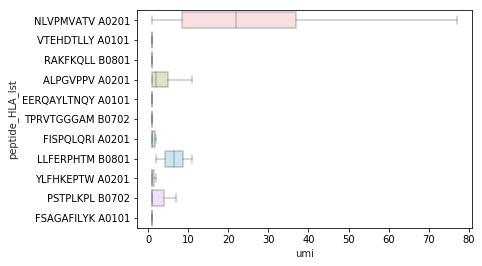

In [80]:
b = sns.boxplot(**ARGS, **PROPS)

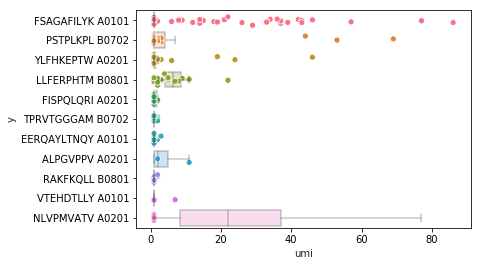

In [129]:
sns.boxplot(**ARGS, **PROPS, order=plt_df.peptide_HLA_lst.unique()[::-1])
sns.scatterplot(data=plt_df, x="umi", y='y', hue='peptide_HLA_lst', legend=False)


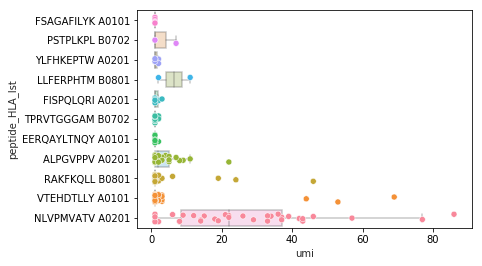

In [180]:
sns.boxplot(**ARGS, **PROPS, order=order) #plt_df.peptide_HLA_lst.unique()[::-1])
s = sns.stripplot(data=plt_df, x="umi", y='peptide_HLA_lst', order=order, hue='peptide_HLA_lst', jitter=0.2, edgecolor='white',linewidth=0.5, size=6) #, hue='peptide_HLA_lst'
s.legend_.remove()

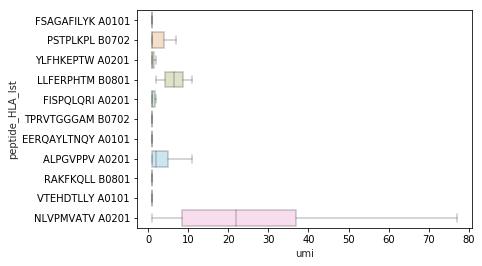

In [181]:
sns.boxplot(**ARGS, **PROPS, order=order)

AttributeError: 'NoneType' object has no attribute 'remove'

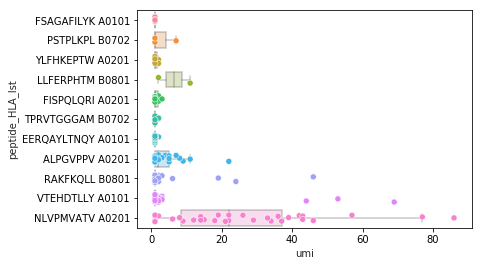

In [184]:
sns.boxplot(**ARGS, **PROPS, order=order)
s = sns.stripplot(data=plt_df, x="umi", y='peptide_HLA_lst', order=order, jitter=0.2, edgecolor='white',linewidth=0.5, size=6) #, hue='peptide_HLA_lst'
s.legend_.remove()

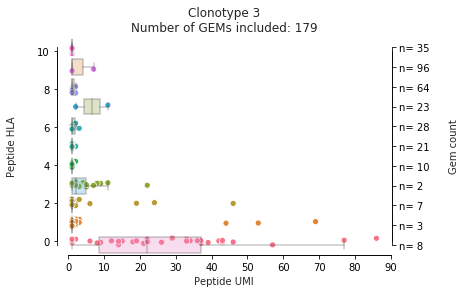

In [92]:
ax = sns.scatterplot(data=plt_df, x="umi", y="y", hue='peptide_HLA_lst', legend=False)
tx = ax.twinx()
#sns.boxplot(**ARGS, ax=tx, **EMPTY) #boxprops=dict(alpha=0)
sns.boxplot(**ARGS, ax=tx, **PROPS, order=plt_df.peptide_HLA_lst.unique()[::-1]) # boxprops=dict(alpha=0.3) #, order=list(b.get_yticklabels())[::-1]
# Fix 2nd yticklabels
#tx.set_yticks(np.arange(len(plt_df.peptide_HLA_lst.unique())))
tx.set_yticklabels([f'n= {n}' for n in plt_df.groupby('peptide_HLA_lst').size()])
tx.set_ylabel('Gem count', labelpad=20)
ax.set_ylabel('Peptide HLA', labelpad=20)
ax.set_xlabel('Peptide UMI')

# Fix x-axis
xmax = round(plt_df.umi.max(), -1)
plt.xticks(np.arange(0, xmax+10, 10),np.arange(0, xmax+10, 10))
ax.spines['bottom'].set_bounds(0, xmax)

sns.despine(trim=True, right=False)
#plt.tick_params(axis='y', which='both', right=True)
plt.title(f'Clonotype 3\nNumber of GEMs included: {n}')
plt.show()

/Users/herpov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


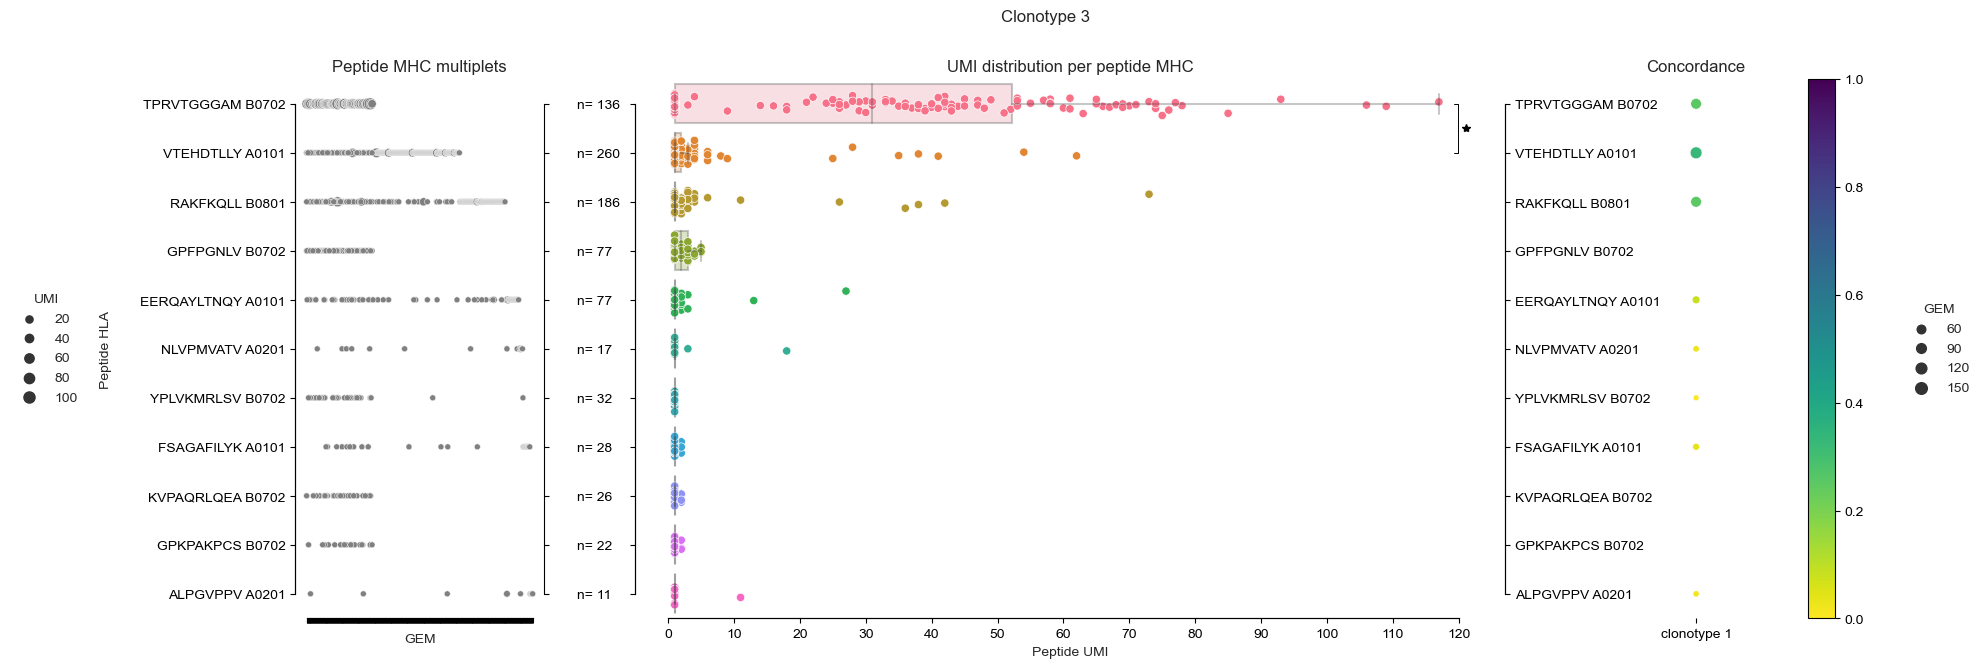

In [81]:
fig = plt.figure(figsize=(20,7))
fig.suptitle(f"Clonotype {ct}")

gs = gridspec.GridSpec(1, 3, width_ratios=[2, 7, 2], wspace=0.2) #, left=0.05
ax1 = fig.add_subplot(gs[0]) #ax1 = plt.subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1]) #ax2 = plt.subplot(gs[0,1])
ax3 = fig.add_subplot(gs[2]) #ax3 = plt.subplot(gs[0, 2])

########################
# Add multipletplot
###############################
tx1 = ax1.twinx()
sns.scatterplot(data=plt_df, x="gem", y='peptide_HLA_lst', size='umi', color="gray", ax=ax1)
sns.scatterplot(data=plt_df, x="gem", y='peptide_HLA_lst', size='umi', color="gray", legend=False, ax=tx1)
ax1.legend(bbox_to_anchor=(-1, 0.5), loc=10, frameon=False, title='UMI')

########################
# Add boxplot
###############################
tx2 = ax2.twinx() # hack to get matching ticks on the right
sns.boxplot(**ARGS, **PROPS, ax=ax2) # boxprops=dict(alpha=0.3)
sns.boxplot(**ARGS, ax=tx2, **EMPTY) #boxprops=dict(alpha=0)
sns.scatterplot(data=plt_df, x="umi", y="y", hue='peptide_HLA_lst', legend=False, ax=ax2)

# Add significance bar
if instance.test_dist():
    y = [0,0,1,1]
    x0 = plt_df.umi.max()
    x1 = x0 * 1.02
    x2 = x0 * 1.025
    x3 = x0 * 1.035

    ax2.plot([x1, x2, x2, x1], y, lw=0.7, c='0') #lw=1.5, 
    ax2.plot(x3, np.mean(y), marker="*", c='0')

######################################
# Add concordance plot
#########################################
# Hack to get colorbar
plot = ax3.scatter([], [], c=[], cmap='viridis_r', vmin=0, vmax=1)
fig.colorbar(plot, ax=ax3)
sns.scatterplot(data=lol, x='clonotype', y='peptide_HLA_lst',
                size='gem', hue='concordance', hue_norm=(0,1), palette='viridis_r', ax=ax3) #g = 

# Remove automatic sns legend for hue, keep only legend for size.
h,l = ax3.get_legend_handles_labels()
ax3.legend(h[-4:], l[-4:], bbox_to_anchor=(1.5, 0.5), loc=6, frameon=False, title='GEM')

######################################
# Prettify
#########################################

ax1.set_title('Peptide MHC multiplets')
ax2.set_title('UMI distribution per peptide MHC')
ax3.set_title('Concordance')

xmax = round(plt_df.umi.max(), -1)
ax2.set_xticks(np.arange(0, xmax+10, 10))
ax3.set_yticks([])

ax1.set_xticklabels([])
tx1.set_yticklabels([f'n= {n}' for n in plt_df.groupby('peptide_HLA_lst').size()])
ax2.set_yticklabels([])
ax3.set_yticklabels([])

ax1.set_xlabel('GEM')
ax1.set_ylabel('Peptide HLA', labelpad=20)
tx1.set_ylabel('')
ax2.set_xlabel('Peptide UMI')
ax2.set_ylabel('')
tx2.set_ylabel('')
ax3.set_ylabel('')
ax3.set_xlabel('')

tx1.tick_params(axis='y', pad=20)

ax2.spines['bottom'].set_bounds(0, xmax) # Hack to fix x-axis

sns.despine(trim=True, right=True, ax=ax1)
sns.despine(trim=True, right=False, ax=tx1)
sns.despine(trim=True, right=False, ax=ax2)
sns.despine(trim=True, right=False, ax=tx2)
sns.despine(trim=True, left=True, ax=ax3) #offset={'left':-5,'right':-5}
plt.show()

# Make GIF

In [24]:
import imageio

In [25]:
import os

In [26]:
filenames = list()
for n in range(plt_df.gem_count.max()+1):
    print(n)
    #if n == 0:
    #    # Initialize the plotting frame
    #    np.random.seed(123)
    #    ax = sns.stripplot(x="umi", y="peptide_HLA_lst", data=plt_df, alpha=0, jitter=True)
    #elif n == plt_df.gem_count.max():
    #    np.random.seed(123)
    #    ax = sns.stripplot(x="umi", y="peptide_HLA_lst", data=plt_df, alpha=0, jitter=True)
    #    ax = sns.boxplot(x="umi", y="peptide_HLA_lst", data=plt_df[plt_df.gem_count <= n], fliersize=0)
    #    ax = sns.stripplot(x="umi", y="peptide_HLA_lst", data=plt_df[plt_df.gem_count <= n], jitter=True)
    #else:
    #    np.random.seed(123)
    #    ax = sns.stripplot(x="umi", y="peptide_HLA_lst", data=plt_df, alpha=0, jitter=True)
    #    ax = sns.stripplot(x="umi", y="peptide_HLA_lst", data=plt_df[plt_df.gem_count <= n], jitter=True)
    
    # Hack to fix axes
    ax = sns.boxplot(**ARGS, **EMPTY) # boxprops=dict(alpha=0.3)
    tx = ax.twinx()
    sns.boxplot(**ARGS, ax=tx, **EMPTY) #boxprops=dict(alpha=0)
    # Plot scatter
    sns.scatterplot(data=plt_df[plt_df.gem_count <= n], x="umi", y="y", hue='peptide_HLA_lst', legend=False)
    
    # Fix 2nd yticklabels
    tx.set_yticklabels([f'n= {n}' for n in plt_df[plt_df.gem_count <= n].groupby('peptide_HLA_lst').size()])
    tx.set_ylabel('Gem count', labelpad=20)
    ax.set_ylabel('Peptide HLA', labelpad=20)
    ax.set_xlabel('Peptide UMI')

    # Fix x-axis
    xmax = round(plt_df.umi.max(), -1)
    plt.xticks(np.arange(0, xmax+10, 10),np.arange(0, xmax+10, 10))
    ax.spines['bottom'].set_bounds(0, xmax)

    sns.despine(trim=True, right=False, offset=5)
    #plt.tick_params(axis='y', which='both', right=True)
    plt.title(f'Clonotype 3\nNumber of GEMs included: {n}')
    
    filename = f'{n}.png'
    filenames.append(filename)
    
    # repeat last frame
    if (n == plt_df.gem_count.max()):
        for i in range(10): # a longer pause before adding boxplots...
            filenames.append(filename)
    else:
        for i in range(2): # Pause between adding points
            filenames.append(filename)
    
    #sns.despine(trim=True, right=False)
    #plt.tick_params(axis='y', which='both', right=True)
    #plt.title(f'Number of GEMs included: {n}')
    ##plt.xlim(0, plt_df.umi.max()+1)
    plt.savefig(filename, bbox_inches='tight')
    plt.close()
    
# Adding boxes!
n += 1
filename = f'{n}.png'
filenames.append(filename)

# repeat last frame
for i in range(50): # a looong pause after adding boxplots...
    filenames.append(filename)

# Plot
ax = sns.boxplot(**ARGS, **PROPS) # boxprops=dict(alpha=0.3)
tx = ax.twinx()
sns.boxplot(**ARGS, ax=tx, **EMPTY) #boxprops=dict(alpha=0)
sns.scatterplot(data=plt_df, x="umi", y="y", hue='peptide_HLA_lst', legend=False)
# Fix 2nd yticklabels
#tx.set_yticks(np.arange(len(plt_df.peptide_HLA_lst.unique())))
tx.set_yticklabels([f'n= {n}' for n in plt_df.groupby('peptide_HLA_lst').size()])
tx.set_ylabel('Gem count', labelpad=20)
ax.set_ylabel('Peptide HLA', labelpad=20)
ax.set_xlabel('Peptide UMI')

# Fix x-axis
xmax = round(plt_df.umi.max(), -1)
plt.xticks(np.arange(0, xmax+10, 10),np.arange(0, xmax+10, 10))
ax.spines['bottom'].set_bounds(0, xmax)

sns.despine(trim=True, right=False, offset=5)
#plt.tick_params(axis='y', which='both', right=True)
plt.title(f'Clonotype 3\nNumber of GEMs included: {n}')
plt.savefig(filename, bbox_inches='tight')
plt.close()

# build gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


In [ ]:
def get_nonsinglet_idxs(duplicated_list):
    dups = collections.defaultdict(list)
    for i, e in enumerate(duplicated_list):
        dups[e].append(i)
    idxs = []
    for k, v in sorted(dups.items()):
        if len(v) > 1:
            idxs += v
    return idxs

In [6]:
def assign_clonotype(tcr_df, clonotype_variables = ['v_gene_TRA','j_gene_TRA','v_gene_TRB','j_gene_TRB','cdr3_comb']):
    
    tcr_df.loc[:, clonotype_variables] = tcr_df.loc[:, clonotype_variables].fillna('unknown')
    new_clonotype = tcr_df.groupby(clonotype_variables).gem.unique().to_frame()
    new_clonotype['n_gems'] = new_clonotype.gem.apply(len)
    new_clonotype.sort_values(by='n_gems', ascending=False, inplace=True)
    dct = new_clonotype.to_dict()['gem']
    for i, k in enumerate(dct.keys(), start=1): 
        dct[k] = i
    return tcr_df.set_index(clonotype_variables).index.map(dct)

#tcr_df['ct'] = assign_clonotype()

# Input

### OBS! exp

In [13]:
INPUT = '/Users/herpov/Documents/mnt/computerome_projects/people/helpov/tcr-pmhc-sc-project/data/exp9.2_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.csv'

In [11]:
#INPUT = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp9_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.imputed.csv'

In [8]:
INPUT = '../data/exp9.2_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.csv'

In [80]:
INPUT = '../experiments/exp13/run2/cat/tables/tcr_barcode.cleaned.csv'
df = pd.read_csv(INPUT, converters=converters) #

# Output

In [11]:
PLT = '/Volumes/tuba/herpov/tcr-pmhc-sc-project/plots/exp9_IONTORRENT_KMA_AKB/reports/mhc_umi_dist_per_ct/'